# Multicollinearity Check

In this notebook, we will evaluate whether there is a problematic level of multicollinearity between our features. Since we are pursuing interpretable model coefficients, it is important that our features aren't highly correlated.

In [ ]:
## Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tools.tools import add_constant

In [ ]:
## Import and preview data
data_df = pd.read_csv('cleaned_data.csv', index_col=0)
data_df.head()

,percent_wind_gen,percent_solar_gen,exports,total_load,total_lmp,battery_en,battery_soc,season_summer,season_spring,season_winter,total_curtailment
0,0.265874,0.0,-69960.360000,21302.162944,114.687870,41.976,6524.477167,0,0,1,0.0
1,0.303146,0.0,-67462.573333,20803.750237,108.752210,-5.863,6460.896417,0,0,1,0.0
2,0.327688,0.0,-65642.693333,20300.078086,102.776174,-54.224,6465.033667,0,0,1,0.0
3,0.326433,0.0,-64974.106667,19914.921017,106.676475,19.609,6460.216500,0,0,1,0.0
4,0.292937,0.0,-65427.986667,19975.842246,110.358796,8.992,6428.138083,0,0,1,0.0


First, we calculate VIF for all of our features by regressing each predictor onto all of the others. We will use a threshold of 5 for VIF. Above this threshold, we will generate interaction terms for highly correlated features.

In [ ]:
# Drop response variable and add constant for statsmodel
vif_df = data_df.copy()
vif_df.drop(['total_curtailment'], axis=1, inplace=True)
vif_df = add_constant(vif_df)

In [ ]:
# Calculate VIF values to understand overall multicollinearity among features
vif_data = pd.DataFrame()
vif_data['feature'] = vif_df.columns

vif_data['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
0,const,74.667787
2,percent_solar_gen,6.296266
3,exports,2.870181
6,battery_en,2.773317
4,total_load,2.328697
7,battery_soc,2.065852
9,season_spring,1.908766
8,season_summer,1.893650
5,total_lmp,1.772129
10,season_winter,1.678390


Percent_solar_gen (% solar generation) has a VIF of 6.29 > 5, so our threshold is exceeded. Next, we will generate a Pearson correlation matrix to determine which features are highly correlated. We will visualize these correlations on a heatmap and generate interaction terms for any correlations > 0.70.

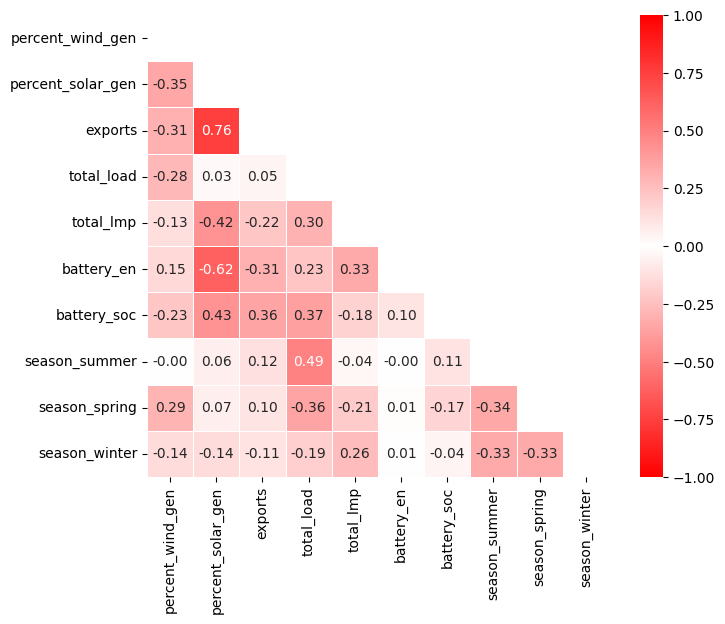

In [ ]:
# Visualize binary correlations between features using Pearson correlation map
vif_df.drop('const', axis=1, inplace=True, errors='ignore')
matrix = vif_df.corr(method='pearson') # Create correlation matrix
mask = np.triu(np.ones_like(matrix, dtype=bool)) # Cut out diagonal and repeated correlations

# Plot heatmap
plt.figure(figsize=(8,6))
cmap = LinearSegmentedColormap.from_list('', ['red', 'white', 'red']) # Color scheme to capture absolute value of correlation
sns.heatmap(matrix, mask=mask, annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, square=True, vmin=-1, vmax=1)

plt.savefig('corr_heatmap.png')
plt.show()

Since percent_solar_gen and exports have a correlation of 0.76, we will add an interaction term: solar_exports.

In [ ]:
## Add an interaction term for correlated features: percent_solar_gen and imports
data_df['solar_exports'] = data_df['percent_solar_gen'] * data_df['exports']

## Reorder columns to have response variable at end
data_df = data_df[['percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load', 'total_lmp', 'battery_en', 'battery_soc', 'season_summer', 'season_spring', 'season_winter','solar_exports', 'total_curtailment']]

In [ ]:
## Save data as CSV
data_df.to_csv('final_data.csv', index=True)